In [72]:
import uproot
import h5py
import numpy as np
import os
import awkward as ak

In [73]:
# pick random file
dir_root_lightjet = '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2/mc20_Run2/Ntuples/PeriodE/ZJets_MG'
subdir_ee = 'user.ltoffoli.mc20_13TeV.506193.MGPy8EG_3jets_HT2bias_BFilter.deriv.DAOD_PHYS.e8382_s3681_r13145_p5631.toffoGN2_v1_output.root'

In [74]:
fname_ee = os.listdir(os.path.join(dir_root_lightjet,subdir_ee))[3]

## di-electron

In [75]:
tree = uproot.open(os.path.join(dir_root_lightjet,subdir_ee,fname_ee)+':nominal')

In [76]:
samples = tree.arrays(['el_e','mu_e','el_charge','mu_charge','el_pt','mu_pt', 'el_phi','mu_phi',\
                      'el_eta', 'mu_eta', 'jet_e'])

In [77]:
samples

<Array [{el_e: [2.04e+05, ... 5.28e+05]}] type='1594528 * {"el_e": var * float32...'>

In [78]:
samples[2].el_phi

<Array [1.25, 0.2] type='2 * float32'>

In [79]:
# sum over both electrons
ee_px = ak.sum(samples.el_pt * np.cos(samples.el_phi),axis=1)
ee_py = ak.sum(samples.el_pt * np.sin(samples.el_phi),axis=1)
ee_pz = ak.sum(samples.el_pt * np.sinh(samples.el_eta),axis=1)

In [80]:
ee_px

<Array [1.74e+05, 4.15e+05, ... -1.03e+05] type='1594528 * float32'>

In [81]:
ee_pt3d = ee_px**2 + ee_py**2 + ee_pz**2
ee_e3d = ak.sum(np.sqrt((samples.el_pt*np.cosh(samples.el_eta))**2 + (511e-3)**2),axis=1)

In [82]:
ee_e3d

<Array [2.55e+05, 5.51e+05, ... 2.2e+05] type='1594528 * float32'>

In [83]:
ee_e3d**2 - ee_pt3d

<Array [7.54e+09, 8.05e+09, ... 7.95e+09] type='1594528 * float32'>

In [84]:
samples['ee_m'] = np.sqrt(ee_e3d**2 - ee_pt3d)

In [85]:
ee_m = samples['ee_m']

## di-muon

In [91]:
subdir_mumu = 'user.ltoffoli.mc20_13TeV.506196.MGPy8EG_3jets_HT2bias_BFilter.deriv.DAOD_PHYS.e8382_s3681_r13145_p5631.toffoGN2_v1_output.root'
fname_mumu = os.listdir(os.path.join(dir_root_lightjet,subdir_mumu))[2]

In [92]:
tree = uproot.open(os.path.join(dir_root_lightjet,subdir_mumu,fname_mumu)+':nominal')

In [93]:
samples = tree.arrays(['el_e','mu_e','el_charge','mu_charge','el_pt','mu_pt', 'el_phi','mu_phi',\
                      'el_eta', 'mu_eta', 'jet_e'])

In [94]:
samples

<Array [{el_e: [], mu_e: [, ... 2.35e+04]}] type='2943751 * {"el_e": var * float...'>

In [95]:
samples[2].mu_phi

<Array [2.77, -0.297] type='2 * float32'>

In [96]:
# sum over both muons
mu_px = ak.sum(samples.mu_pt * np.cos(samples.mu_phi),axis=1)
mu_py = ak.sum(samples.mu_pt * np.sin(samples.mu_phi),axis=1)
mu_pz = ak.sum(samples.mu_pt * np.sinh(samples.mu_eta),axis=1)

In [97]:
mu_pt3d = mu_px**2 + mu_py**2 + mu_pz**2
mu_e3d = ak.sum(np.sqrt((samples.mu_pt*np.cosh(samples.mu_eta))**2 + (105.7)**2),axis=1)

In [99]:
samples['mumu_m'] = np.sqrt(mu_e3d**2 - mu_pt3d)

In [100]:
mumu_m = samples['mumu_m']

In [101]:
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import numpy as np
import mplhep as hep

In [102]:
palette = ['#3E96A1', '#EC4E20', '#FF9505', '#713E5A', '#D62828', '#5F0F40']

In [103]:
def get_bg_idx(sample_names, bg_name):

    if bg_name is not None:
        return [i for (i,s) in enumerate(sample_names) if bg_name in s][0]
    else:
        return -1

In [104]:
def plot_feature_for_n_samples(data, sample_names, bins=100, xlabel='x', ylabel='fraction events', title=None, clip_outlier=False, normed=True, \
    ylogscale=True, xlim=None, plot_name='feature_hist', fig_dir=None, fig_format='.pdf', fig_size=(7,7), bg_name=None, histtype_bg='stepfilled', \
    show_plt=False, legend_outside=True):
    '''
    plots single feature distribution for multiple samples as 1D histogram
    :param data: list of J ndarrays of each N feature values
    :param bg_name: if not None, one sample will be treated as background and plotted in histtype_bg style
    '''

    # import ipdb; ipdb.set_trace()

    # if one sample is to be treated as background sample
    bg_idx = get_bg_idx(sample_names, bg_name)

    plt.style.use(hep.style.CMS)

    fig = plt.figure(figsize=(7,5))
    if ylogscale:
        plt.yscale('log')

    for i, (dat, col) in enumerate(zip(data, palette)):
        if i == bg_idx:
            plt.hist(dat, bins=bins, density=normed, alpha=0.5, histtype=histtype_bg, label=sample_names[i], color=col)
        else:
            plt.hist(dat, bins=bins, density=normed, alpha=1.0, histtype='step', label=sample_names[i], color=col)

    if xlim:
        plt.xlim(xlim)
    plt.grid()
    plt.gca().tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    if legend_outside:
        handles, labels = plt.gca().get_legend_handles_labels()
        lgd = fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.1), loc="lower center", ncol=len(data), labelspacing=0.8, fontsize=16)
        bbox_extra_artists = (lgd,)
    else:
        plt.legend(loc='best', fontsize=15)
        bbox_extra_artists = None
    plt.tight_layout()
    if show_plt:
        plt.show()
    if fig_dir:
        print('writing figure to ' + os.path.join(fig_dir, plot_name + fig_format))
        fig.savefig(os.path.join(fig_dir, plot_name + fig_format), bbox_extra_artists=bbox_extra_artists, bbox_inches='tight')
    plt.close(fig)


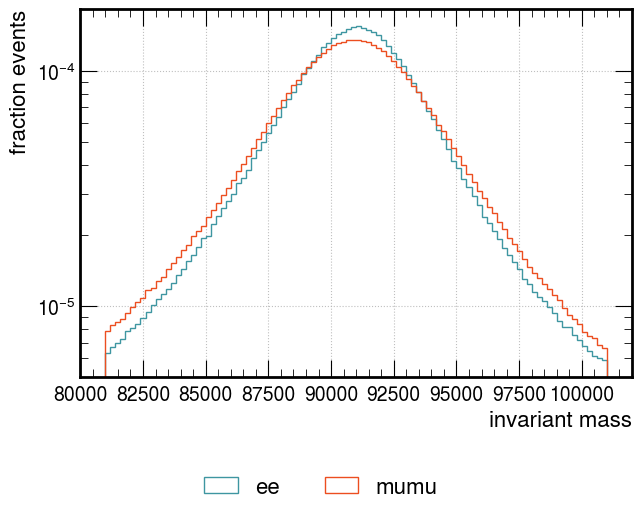

In [106]:
data = [ee_m, mumu_m]
sample_names = ['ee','mumu']
plot_feature_for_n_samples(data,sample_names,xlabel='invariant mass',show_plt=True)

In [119]:
sum((ee_m > 80e3) & (ee_m < 100e3))

1584543